In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [102]:
from pathlib import Path
import json
import cv2
import os
from typing import Union
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
from collections import defaultdict, namedtuple
from sklearn.preprocessing import MultiLabelBinarizer
import random
import pandas as pd
import numpy as np

In [6]:
import torch
import torchvision
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset

In [7]:
PATH = Path('./VOCdevkit/VOC2007/')
JSON_PATH = Path('.')

In [8]:
img_size = 300
batch_size = 64

In [9]:
torch.cuda.set_device(2)

In [10]:
torch.cuda.current_device()

2

# EDA

In [11]:
list(PATH.iterdir())

[PosixPath('VOCdevkit/VOC2007/Annotations'),
 PosixPath('VOCdevkit/VOC2007/model-bb1-s1.pth'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('VOCdevkit/VOC2007/model-bb1-s2.pth'),
 PosixPath('VOCdevkit/VOC2007/model-cls-s1.pth'),
 PosixPath('VOCdevkit/VOC2007/model-cls-s2.pth'),
 PosixPath('VOCdevkit/VOC2007/ImageSets'),
 PosixPath('VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('VOCdevkit/VOC2007/tmp'),
 PosixPath('VOCdevkit/VOC2007/mode_tmp.pth'),
 PosixPath('VOCdevkit/VOC2007/.ipynb_checkpoints'),
 PosixPath('VOCdevkit/VOC2007/SegmentationObject')]

In [12]:
list(JSON_PATH.iterdir())

[PosixPath('.git'),
 PosixPath('pascal_val2007.json'),
 PosixPath('pascal_test2007.json'),
 PosixPath('VOCdevkit'),
 PosixPath('object_detection.ipynb'),
 PosixPath('make_prior_boxes.ipynb'),
 PosixPath('pascal_val2012.json'),
 PosixPath('class_dev.ipynb'),
 PosixPath('pascal_train2007.json'),
 PosixPath('README.md'),
 PosixPath('src'),
 PosixPath('pascal_train2012.json'),
 PosixPath('.gitignore'),
 PosixPath('.ipynb_checkpoints')]

## Metadata

In [13]:
annotations = json.load(open(JSON_PATH/'pascal_train2007.json'))

In [14]:
annotations.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [15]:
annotations['categories']

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'},
 {'supercategory': 'none', 'id': 6, 'name': 'bus'},
 {'supercategory': 'none', 'id': 7, 'name': 'car'},
 {'supercategory': 'none', 'id': 8, 'name': 'cat'},
 {'supercategory': 'none', 'id': 9, 'name': 'chair'},
 {'supercategory': 'none', 'id': 10, 'name': 'cow'},
 {'supercategory': 'none', 'id': 11, 'name': 'diningtable'},
 {'supercategory': 'none', 'id': 12, 'name': 'dog'},
 {'supercategory': 'none', 'id': 13, 'name': 'horse'},
 {'supercategory': 'none', 'id': 14, 'name': 'motorbike'},
 {'supercategory': 'none', 'id': 15, 'name': 'person'},
 {'supercategory': 'none', 'id': 16, 'name': 'pottedplant'},
 {'supercategory': 'none', 'id': 17, 'name': 'sheep'},
 {'supercategory': 'none', 'id': 18, 'name': 'sofa'},
 {'super

In [16]:
annotations['annotations'][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [17]:
annotations['categories'][0]

{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}

In [18]:
categories = {d['id']:d['name'] for d in annotations['categories']}
categories

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

## Images

In [19]:
IMG_PATH = PATH/'JPEGImages'
list(IMG_PATH.iterdir())[:5]

[PosixPath('VOCdevkit/VOC2007/JPEGImages/007622.jpg'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages/000450.jpg'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages/002505.jpg'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages/003271.jpg'),
 PosixPath('VOCdevkit/VOC2007/JPEGImages/006858.jpg')]

In [20]:
annotations['images'][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [377]:
def bounding_box(bb):
    """switch x/y coords to be consistent with numpy, convert height/width into top-left/bottom-right"""
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

# make dictionary {img_id:[(cat_id, bbox), (cat_id, bbox), ...]}
def make_anno_dict(anno_json):
    anno_dict = defaultdict(list)
    for anno in anno_json['annotations']:
        if not anno['ignore']:
    #         bb = bounding_box(anno['bbox'])
            bb = np.array(anno['bbox'])  # matplotlib accepts VOC format bounding box, so no need to convert
            anno_dict[anno['image_id']].append(
                (anno['category_id'], bb))
    return anno_dict

# open image
def load_image(img_path):
    img = cv2.imread(str(img_path)).astype(np.float32)/255
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    return ax


def draw_outline(plt_object, lw):
    plt_object.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])


def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(
        b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)


def draw_text(ax, xy, txt, font_sz=14):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color='white', fontsize=font_sz, weight='bold')
    draw_outline(text, 1)

def show_by_index(idx:int, annotations:dict):
    img_path = str(IMG_PATH/f'{idx:06d}.jpg')
    img = load_image(img_path)
    
    if idx in annotations.keys():
        print(img_path)
        ax = show_img(img, figsize=(12, 12))
        for item in annotations[idx]:
            b = item[1]
            print(f'Bounding box:\nY: {b[1]}\nX: {b[0]}\nHeight: {b[3]}\nWidth: {b[2]}')
            draw_rect(ax, b)
            draw_text(ax, b[:2], categories[item[0]])

In [22]:
train_anno = make_anno_dict(annotations)

VOCdevkit/VOC2007/JPEGImages/007908.jpg
Bounding box:
Y: 1
X: 190
Height: 332
Width: 310


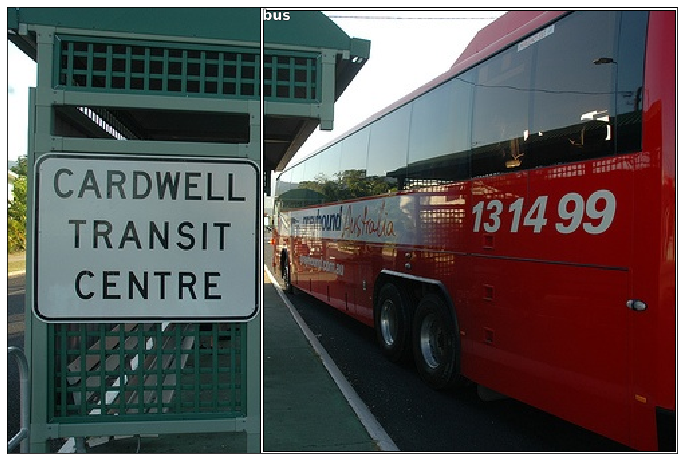

In [23]:
img_ids = list(train_anno.keys())
idx = random.sample(img_ids, 1)[0]
show_by_index(idx, train_anno)

# Single Object Detection

Start from classifying the largest bounding box in an image

## Select the largest bounding box

In [24]:
def get_largest_box(b):
    try:
        max_box = sorted(b, key=lambda x: abs(np.product(x[1][-2:])), reverse=True)
        return max_box[0]
    except:
        raise Exception()

In [25]:
max_train_anno = {k:[get_largest_box(v)] for k,v in train_anno.items()}

VOCdevkit/VOC2007/JPEGImages/009466.jpg
Bounding box:
Y: 219
X: 156
Height: 217
Width: 242


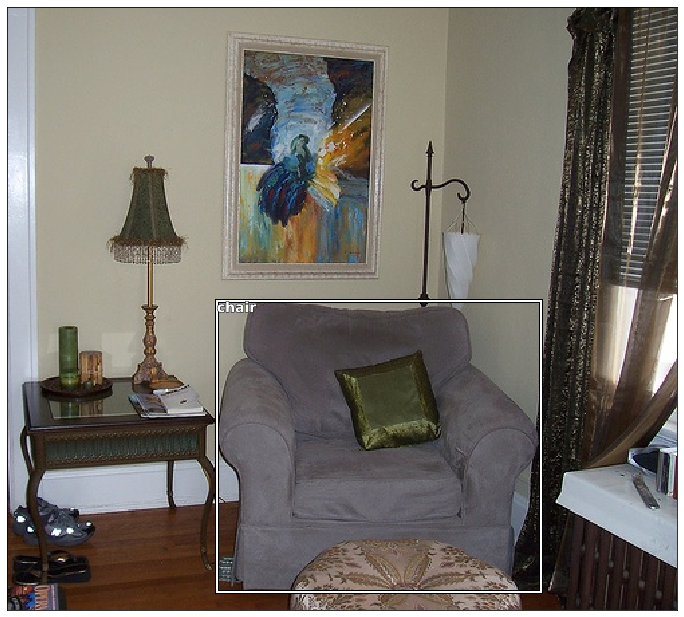

In [21]:
train_ids_max = list(max_train_anno.keys())
idx = random.sample(train_ids_max, 1)[0]
show_by_index(idx, max_train_anno)

## Create labels for multi-class classification

In [26]:
train_labels = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in train_anno.keys()],
                'label': [categories[max_train_anno[idx][0][0]] for idx in train_anno.keys()]}

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_encoded = le.fit_transform(sorted(set(train_labels['label'])))
label_encoding = dict(zip(sorted(set(train_labels['label'])), label_encoded))
label_encoding

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

### Training set

In [24]:
train_labels_df = pd.DataFrame.from_dict(train_labels, orient='columns')

In [26]:
train_labels_df['label'] = train_labels_df['label'].apply(lambda x: label_encoding[x])

In [27]:
train_labels_df.head(5)

,fn,label
0,VOCdevkit/VOC2007/JPEGImages/000012.jpg,6
1,VOCdevkit/VOC2007/JPEGImages/000017.jpg,12
2,VOCdevkit/VOC2007/JPEGImages/000023.jpg,14
3,VOCdevkit/VOC2007/JPEGImages/000026.jpg,6
4,VOCdevkit/VOC2007/JPEGImages/000032.jpg,0


In [28]:
train_labels_df['label'].value_counts()

14    594
6     292
2     167
7     139
11    137
18    124
12    118
0     112
13     95
8      89
17     87
5      86
10     76
3      75
15     61
9      59
1      58
19     54
16     42
4      36
Name: label, dtype: int64

In [ ]:
(PATH/'tmp').mkdir(exist_ok=True)

In [ ]:
train_labels_df.to_csv(PATH/'tmp/train_label.csv', sep=',', index=False, header=True)

### Validation set

In [28]:
vals = json.load(open(JSON_PATH/'pascal_val2007.json'))

In [29]:
val_anno = make_anno_dict(vals)

In [50]:
max_val_anno = {k:[get_largest_box(v)] for k,v in val_anno.items()}

In [51]:
val_ids_max = list(max_val_anno.keys())
val_labels = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in val_ids_max],
              'label': [categories[max_val_anno[idx][0][0]] for idx in val_ids_max]}

In [52]:
val_labels_df = pd.DataFrame.from_dict(val_labels, orient='columns')
val_labels_df['label'] = val_labels_df['label'].apply(lambda x: label_encoding[x])
val_labels_df.head(5)

,fn,label
0,VOCdevkit/VOC2007/JPEGImages/000005.jpg,8
1,VOCdevkit/VOC2007/JPEGImages/000007.jpg,6
2,VOCdevkit/VOC2007/JPEGImages/000009.jpg,12
3,VOCdevkit/VOC2007/JPEGImages/000016.jpg,1
4,VOCdevkit/VOC2007/JPEGImages/000019.jpg,7


In [ ]:
val_labels_df.to_csv(PATH/'tmp/val_label.csv', sep=',', index=False, header=True)

## Creating labels for single bounding box

In [53]:
train_bbox = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in train_ids_max],
              'label': [categories[max_train_anno[idx][0][0]] for idx in train_ids_max],
              'bbox': [max_train_anno[idx][0][1] for idx in train_ids_max]}

In [54]:
val_bbox = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in val_ids_max],
            'label': [categories[max_val_anno[idx][0][0]] for idx in val_ids_max],
            'bbox': [max_val_anno[idx][0][1] for idx in val_ids_max]}

In [55]:
train_bbox_df = pd.DataFrame.from_dict(train_bbox, orient='columns')
train_bbox_df['bbox'] = train_bbox_df['bbox'].apply(lambda x: ' '.join(str(p) for p in x))
train_bbox_df['label'] = train_bbox_df['label'].apply(lambda x: label_encoding[x])
train_bbox_df.head(5)

,fn,label,bbox
0,VOCdevkit/VOC2007/JPEGImages/000012.jpg,6,155 96 196 174
1,VOCdevkit/VOC2007/JPEGImages/000017.jpg,12,89 77 314 259
2,VOCdevkit/VOC2007/JPEGImages/000023.jpg,14,2 1 241 461
3,VOCdevkit/VOC2007/JPEGImages/000026.jpg,6,89 124 248 88
4,VOCdevkit/VOC2007/JPEGImages/000032.jpg,0,103 77 272 106


In [56]:
val_bbox_df = pd.DataFrame.from_dict(val_bbox, orient='columns')
val_bbox_df['bbox'] = val_bbox_df['bbox'].apply(lambda x: ' '.join(str(p) for p in x))
val_bbox_df['label'] = val_bbox_df['label'].apply(lambda x: label_encoding[x])
val_bbox_df.head(5)

,fn,label,bbox
0,VOCdevkit/VOC2007/JPEGImages/000005.jpg,8,164 263 89 109
1,VOCdevkit/VOC2007/JPEGImages/000007.jpg,6,140 49 360 281
2,VOCdevkit/VOC2007/JPEGImages/000009.jpg,12,68 171 202 159
3,VOCdevkit/VOC2007/JPEGImages/000016.jpg,1,91 71 214 402
4,VOCdevkit/VOC2007/JPEGImages/000019.jpg,7,230 87 253 169


In [ ]:
train_bbox_df.to_csv(PATH/'tmp/train_bbox.csv', sep=',', index=False, header=True)

In [ ]:
val_bbox_df.to_csv(PATH/'tmp/val_bbox.csv', sep=',', index=False, header=True)

## Creating labels for multi-label classification

In [91]:
train_labels_multi = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in train_anno.keys()],
                      'label': [list(zip(*train_anno[idx]))[0] for idx in train_anno.keys()]}

In [92]:
val_labels_multi = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in val_anno.keys()],
                    'label': [list(zip(*val_anno[idx]))[0] for idx in val_anno.keys()]}

In [115]:
train_labels_multi_df = pd.DataFrame.from_dict(train_labels_multi, orient='columns')
train_labels_multi_df['label'] = train_labels_multi_df['label'].apply(lambda x: set(x))\
                                                               .apply(lambda x: ' '.join([str(n) for n in x]))
train_labels_multi_df.head(5)

,fn,label
0,VOCdevkit/VOC2007/JPEGImages/000012.jpg,7
1,VOCdevkit/VOC2007/JPEGImages/000017.jpg,13 15
2,VOCdevkit/VOC2007/JPEGImages/000023.jpg,2 15
3,VOCdevkit/VOC2007/JPEGImages/000026.jpg,7
4,VOCdevkit/VOC2007/JPEGImages/000032.jpg,1 15


In [116]:
val_labels_multi_df = pd.DataFrame.from_dict(val_labels_multi, orient='columns')
val_labels_multi_df['label'] = val_labels_multi_df['label'].apply(lambda x: set(x))\
                                                           .apply(lambda x: ' '.join([str(n) for n in x]))
val_labels_multi_df.head(5)

,fn,label
0,VOCdevkit/VOC2007/JPEGImages/000005.jpg,9
1,VOCdevkit/VOC2007/JPEGImages/000007.jpg,7
2,VOCdevkit/VOC2007/JPEGImages/000009.jpg,13 15
3,VOCdevkit/VOC2007/JPEGImages/000016.jpg,2
4,VOCdevkit/VOC2007/JPEGImages/000019.jpg,8


In [118]:
train_labels_multi_df.to_csv(PATH/'tmp/train_labels_multi.csv', sep=',', index=False, header=True)

In [119]:
val_labels_multi_df.to_csv(PATH/'tmp/val_labels_multi.csv', sep=',', index=False, header=True)

## Creating labels for multi-bounding-boxed detection

In [27]:
train_bbox_multi = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in train_anno.keys()],
                    'label': [list(zip(*train_anno[idx]))[0] for idx in train_anno.keys()],
                    'bbox': [np.hstack([*list(zip(*train_anno[idx]))[1]]) for idx in train_anno.keys()]}

In [28]:
val_bbox_multi = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in val_anno.keys()],
                  'label': [list(zip(*val_anno[idx]))[0] for idx in val_anno.keys()],
                  'bbox': [np.hstack([*list(zip(*val_anno[idx]))[1]]) for idx in val_anno.keys()]}

In [30]:
train_bbox_multi_df = pd.DataFrame.from_dict(train_bbox_multi, orient='columns')
train_bbox_multi_df['label'] = train_bbox_multi_df['label'].apply(lambda x: ' '.join([str(n) for n in x]))
train_bbox_multi_df['bbox'] = train_bbox_multi_df['bbox'].apply(lambda x: ' '.join([str(n) for n in x]))
train_bbox_multi_df.head(5)

,fn,label,bbox
0,VOCdevkit/VOC2007/JPEGImages/000012.jpg,7,155 96 196 174
1,VOCdevkit/VOC2007/JPEGImages/000017.jpg,15 13,184 61 95 138 89 77 314 259
2,VOCdevkit/VOC2007/JPEGImages/000023.jpg,2 2 15 15 15,8 229 237 271 229 219 105 281 1 0 116 369 2 1 ...
3,VOCdevkit/VOC2007/JPEGImages/000026.jpg,7,89 124 248 88
4,VOCdevkit/VOC2007/JPEGImages/000032.jpg,1 1 15 15,103 77 272 106 132 87 65 36 194 179 19 50 25 1...


In [31]:
val_bbox_multi_df = pd.DataFrame.from_dict(val_bbox_multi, orient='columns')
val_bbox_multi_df['label'] = val_bbox_multi_df['label'].apply(lambda x: ' '.join([str(n) for n in x]))
val_bbox_multi_df['bbox'] = val_bbox_multi_df['bbox'].apply(lambda x: ' '.join([str(n) for n in x]))
val_bbox_multi_df.head(5)

,fn,label,bbox
0,VOCdevkit/VOC2007/JPEGImages/000005.jpg,9 9 9,262 210 62 129 164 263 89 109 240 193 55 106
1,VOCdevkit/VOC2007/JPEGImages/000007.jpg,7,140 49 360 281
2,VOCdevkit/VOC2007/JPEGImages/000009.jpg,13 15 15 15,68 171 202 159 149 140 80 144 284 200 43 131 2...
3,VOCdevkit/VOC2007/JPEGImages/000016.jpg,2,91 71 214 402
4,VOCdevkit/VOC2007/JPEGImages/000019.jpg,8 8,230 87 253 169 10 112 256 147


In [32]:
train_bbox_multi_df.to_csv(PATH/'tmp/train_bbox_multi.csv', sep=',', index=False, header=True)

In [33]:
val_bbox_multi_df.to_csv(PATH/'tmp/val_bbox_multi.csv', sep=',', index=False, header=True)

# Image Augmentation

In [30]:
# When using pre-trained networks you should normalized your images in the same way the
# authors of the model did.
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

def denormalize(im):
    """Denormalizes images."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im * imagenet_stats[1]) + imagenet_stats[0]

## For images

In [31]:
import math
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, bbox=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if bbox:
        return cv2.warpAffine(im, M, (c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## For bounding boxes  

width-height format => bounding-box format => pixel format => resized pixel format => bounding-box format => width-height format

In [88]:
def make_bb_px(y, x):
    """Makes an image of size x retangular bounding box"""
    r, c, *_ = x.shape
    Y = np.zeros((r, c))
#     print(y)
    y = hw_bb(y).astype(np.int)
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y


def to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def hw_bb(bb): 
    """Transform from width-height format to bounding box format.
    
    width-height: [X, Y, width, height]
    bounding-box: [Y, X, left-bottom, right-top]
    """
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])


def bb_hw(bb): 
    """Transform from bounding box format to width-height format.
    
    width-height: [X, Y, width, height]
    bounding-box: [Y, X, left-bottom, right-top]
    """
    return np.array([bb[1], bb[0], bb[3]-bb[1]+1, bb[2]-bb[0]+1])

### test bounding box resize

In [220]:
def tsfm(x, bbox, size=300):
    random_degree = (np.random.random()-.50)*20
    Y = make_bb_px(bbox, x)

    # resize
    x = cv2.resize(x, (size, size))
    y = cv2.resize(Y, (size, size))
    # then rotate
    x = rotate_cv(x, random_degree)
    y = rotate_cv(y, random_degree, bbox=True)
    # then random flip
    if np.random.random() > 0.5: 
        x = np.fliplr(x).copy()
        y = np.fliplr(y).copy()

    return x, bb_hw(to_bb(y))

In [221]:
data_bb = train_bbox_df.iloc[20, :]
X_bb = load_image(data_bb[0])
y_bb = np.array([int(c) for c in data_bb[2].split()])
X, Y = tsfm(X_bb, y_bb)

In [222]:
X_bb_tsfm = cv2.resize(X_bb, (img_size, img_size))
y_bb_tsfm = to_bb(cv2.resize(Y, (img_size, img_size)))

In [223]:
X = [X_bb, X]
Y = [y_bb, Y]

Bounding box:
Y: 50
X: 21
Height: 241
Width: 296
Bounding box:
Y: 39.0
X: 109.0
Height: 195.0
Width: 180.0


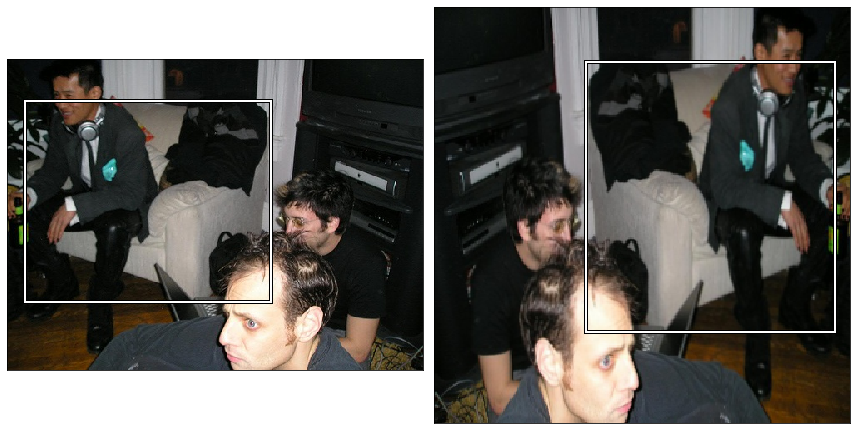

In [224]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    img = X[i]
    b = Y[i]
    ax = show_img(img, ax=ax)
    print(f'Bounding box:\nY: {b[1]}\nX: {b[0]}\nHeight: {b[3]}\nWidth: {b[2]}')
    draw_rect(ax, b)
plt.tight_layout()

# Modelling

To detect multiple bounding boxes, we need to add one more class to the existing categories: background.

In [489]:
from src.transform import __boxtools__
from src.ssd import ssd_prior

In [51]:
categories_bb = categories.copy()
categories_bb[0] = 'background'

In [52]:
categories_bb.values()

dict_values(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'background'])

In [540]:
categories_bb

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor',
 0: 'background'}

## Load data

In [53]:
train_bbox_multi_df = pd.read_csv(PATH/'tmp/train_bbox_multi.csv')
val_bbox_multi_df = pd.read_csv(PATH/'tmp/val_bbox_multi.csv')

In [54]:
train_bbox_multi_df.head(5)

,fn,label,bbox
0,VOCdevkit/VOC2007/JPEGImages/000012.jpg,7,155 96 196 174
1,VOCdevkit/VOC2007/JPEGImages/000017.jpg,15 13,184 61 95 138 89 77 314 259
2,VOCdevkit/VOC2007/JPEGImages/000023.jpg,2 2 15 15 15,8 229 237 271 229 219 105 281 1 0 116 369 2 1 ...
3,VOCdevkit/VOC2007/JPEGImages/000026.jpg,7,89 124 248 88
4,VOCdevkit/VOC2007/JPEGImages/000032.jpg,1 1 15 15,103 77 272 106 132 87 65 36 194 179 19 50 25 1...


In [80]:
IMG_PATH = PATH/'JPEGImages'

In [658]:
class multiBboxDataset(Dataset):
    def __init__(self, root, dataset, transform=False, target_transform=None, sz=img_size, is_test=False):
        self.root = Path(root)
        self.dataset = self.make_anno_dict(dataset)
        self.sz = img_size
        self.transform = transform
        self.target_transform = target_transform
        self.is_test = is_test
        self.classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
                        'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
                        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'background']
        self.class_dict = {i:class_name for i, class_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        image = self.get_image(i)
        labels = self.dataset[i]['labels']
        boxes = self.dataset[i]['boxes']
        if self.transform:
            image, boxes = self.tsfm(image, boxes, self.sz)
        if self.target_transform:
            if not isinstance(boxes, np.ndarray):
                boxes = np.array(boxes)
            locations, labels = self.target_transform(boxes, labels)
        image = normalize(image)
        return image.transpose(2, 0, 1), labels, locations
    
    def tsfm(self, x, bbox, size):
        random_degree = (np.random.random()-.50)*20
        Y = []
        for b in bbox:
            Y.append(make_bb_px(b, x))

        # rotate
        x_resize = cv2.resize(x, (self.sz, self.sz))
        x_rot = rotate_cv(x_resize, random_degree)
        Y_rot = [None] * len(Y)
        for i, b in enumerate(Y):
            y_resize = cv2.resize(b, (self.sz, self.sz))
            Y_rot[i] = rotate_cv(y_resize, random_degree, bbox=True)
        
        # random flip
        if np.random.random() > 0.5:
            x_flip = np.fliplr(x_rot).copy()
            Y_flip = np.fliplr(np.array(Y_rot)).copy()
            
            Y_flip = np.array([bb_hw(to_bb(y)) for y in Y_flip])
            _, Y_flip, _ = __boxtools__.to_percent_coords(x_flip, Y_flip)
            return x_flip, Y_flip
        
        Y_rot = np.array([bb_hw(to_bb(y)) for y in Y_rot])
        _, Y_rot, _ = __boxtools__.to_percent_coords(x_rot, Y_rot)
        return x_rot, Y_rot
    
    def get_image(self, index):
        image_path = str(self.root/self.dataset[index]['img_name'])
        image = load_image(image_path)
        return image
    
    def make_anno_dict(self, df):
        out = []
        for row in df.values:
            anno_dict = dict()
            anno_dict['img_name'] = row[0].split('/')[-1]
            anno_dict['labels'] = np.array([int(x) for x in row[1].split()])
            bbs = row[2].split()
            anno_dict['boxes'] = np.array([bbs[i*4:i*4+4] for i in range(int(len(bbs)/4))], dtype=np.float)
    #         for i, coords in enumerate(anno_dict['boxes']):
    #             anno_dict['boxes'][i] = [float(x) for x in coords]
            out.append(anno_dict)
        return out

In [652]:
SSDBoxSizes = namedtuple('SSDBoxSizes', ['min', 'max'])
SSDSpec = namedtuple('SSDSpec', ['feature_map_size', 'shrinkage', 'box_sizes', 'aspect_ratios'])

specs = [
        SSDSpec(38, 8, SSDBoxSizes(30, 60), [2]),
        SSDSpec(19, 16, SSDBoxSizes(60, 111), [2, 3]),
        SSDSpec(10, 32, SSDBoxSizes(111, 162), [2, 3]),
        SSDSpec(5, 64, SSDBoxSizes(162, 213), [2, 3]),
        SSDSpec(3, 100, SSDBoxSizes(213, 264), [2]),
        SSDSpec(1, 300, SSDBoxSizes(264, 315), [2])
        ]

In [653]:
center_variance = 0.1
size_variance = 0.2
iou_threshold = 0.45
priors = __boxtools__.generate_ssd_priors(specs, image_size=img_size, clip=True)

target_transform = ssd_prior.MatchPrior(priors, center_variance,
                                        size_variance, iou_threshold)

In [659]:
voc_multibb_train = multiBboxDataset(IMG_PATH, train_bbox_multi_df, transform=True,
                                     target_transform=target_transform, sz=img_size, is_test=False)
# voc_multibb_valid = multiBboxDataset(IMG_PATH, val_bbox_multi_df, transform=True, target_transform=None,
#                                      sz=img_size, is_test=True)

In [660]:
train_dl = DataLoader(voc_multibb_train, batch_size=batch_size, shuffle=True)
# val_dl = DataLoader(voc_multibb_valid, batch_size=batch_size)

In [661]:
X, y_label, y_bb = next(iter(train_dl))

In [662]:
X.shape, y_label.shape, y_bb.shape

(torch.Size([64, 3, 300, 300]),
 torch.Size([64, 8732]),
 torch.Size([64, 8732, 4]))

47
[8731]
[139.76593036  45.          96.         200.        ]
15


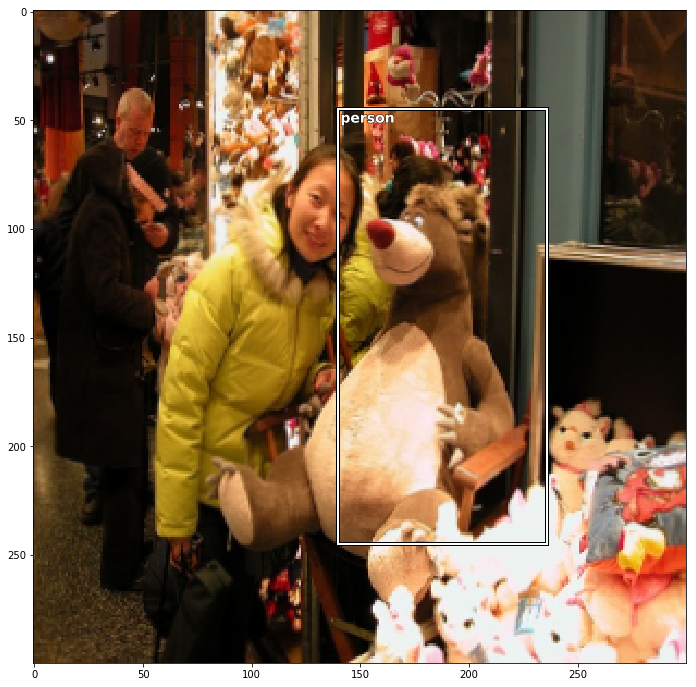

In [678]:
# check augmentation of bounding box
idx = random.randrange(64)
print(idx)
img = denormalize(X[idx].permute(1, 2, 0).numpy())
ax = show_img(img, figsize=(12, 12))
i_s = np.where(y_label.numpy()[idx] != 0)[0]
print(i_s)
for i in i_s:
    # center form real box
    bb_real = __boxtools__.convert_locations_to_boxes(y_bb[idx][i].unsqueeze(0), priors,
                                                      center_variance, size_variance)
    _, box, _ = __boxtools__.to_absolute_coords(img, 
                                                boxes=__boxtools__.center_hw(bb_real[i]).reshape(1, -1),
                                                labels=None)
    print(box[0])
    print(y_label[idx][i].item())
    draw_rect(ax, box[0])
    text = categories_bb[y_label[idx][i].item()]
    draw_text(ax, box[0][:2]+1, text)

## Learning Rate Finder

In [34]:
def get_optimizer(model, lr=1e-2, mom=0.9):
    optim = torch.optim.SGD([
        {'params': model.top_model[0:4].parameters(), 'lr': lr/10, 'momentum': mom},
        {'params': model.top_model[4:8].parameters(), 'lr ':lr/3, 'momentum': mom},
        {'params': model.bn1.parameters()},
        {'params': model.bn2.parameters()},
        {'params': model.fc1.parameters()},
        {'params': model.fc2.parameters()}
    ], lr=lr, momentum=mom)
    return optim

In [35]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)
    
def load_model(m, p):
    checkpoint = torch.load(p)
    m.load_state_dict(checkpoint)
    del checkpoint
    torch.cuda.empty_cache()

In [36]:
def even_mults(start: float, stop: float, n: int)->np.ndarray:
    """Build log-stepped array from `start` to `stop` in `n` steps evenly."""
    mult = stop/start
    step = mult**(1/(n-1))
    return np.array([start*(step**i) for i in range(n)])


def lr_range(lr: Union[float, slice], n)->np.ndarray:
    """Build differential learning rates from `lr`."""
    if not isinstance(lr, slice):
        return lr
    if lr.start:
        lrs = even_mults(lr.start, lr.stop, n)
    else:
        lrs = [lr.stop/10] * (n-1) + [lr.stop]
    return np.array(lrs)

In [42]:
# def get_triangular_lr(lr_low, lr_high, stepesize):
#     iterations = 2*stepesize
#     iter1 = int(0.35*iterations)
#     iter2 = int(0.85*iter1)
#     iter3 = iterations - iter1 - iter2
#     delta1 = (lr_high - lr_low)/iter1
#     delta2 = (lr_high - lr_low)/(iter1 -1)
#     lrs1 = [lr_low + i*delta1 for i in range(iter1)]
#     lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
#     delta2 = (lrs2[-1] - lr_low)/(iter3)
#     lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
#     return lrs1+lrs2+lrs3

In [38]:
def get_triangular_mom(mom_low=0.85, mom_high=0.95, iterations=50):
    iter1 = int(0.45 * iterations)
    iter2 = int(1.0 * iter1)
    iter3 = iterations - iter1 - iter2

    delta_1 = (mom_high - mom_low) / iter1
    delta_2 = (mom_high - mom_low) / (iter2 - 1)
    moms1 = [mom_high - i * delta_1 for i in range(iter1)]
    moms2 = [mom_low + i * delta_2 for i in range(0, iter2)]
    moms3 = [moms2[-1] for i in range(1, iter3 + 1)]

    return moms1 + moms2 + moms3

In [39]:
def get_triangular_lr(lr_optimal, div_factor, iterations):
    iter1 = int(0.45 * iterations)
    iter2 = int(1.0 * iter1)
    iter3 = iterations - iter1 - iter2

    lr_low = lr_optimal/div_factor
    lr_high = lr_optimal

    delta_1 = (lr_high - lr_low) / iter1
    delta_2 = (lr_high - lr_low) / (iter2 - 1)
    lrs1 = [lr_low + i * delta_1 for i in range(iter1)]
    lrs2 = [lr_high - i * delta_2 for i in range(0, iter2)]
    delta_3 = (lrs2[-1] - lr_low / 100) / iter3
    lrs3 = [lrs2[-1] - i * delta_3 for i in range(1, iter3 + 1)]

    return lrs1 + lrs2 + lrs3

In [43]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): 
        p.requires_grad = b

def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [44]:
def detn_loss(out_class, y_class, out_bb, y_bb):
    out_bb = torch.sigmoid(out_bb)*224
    # cross entropy: around 2-3
    # l1 loss: >90
    return F.l1_loss(out_bb, y_bb)/30 + F.cross_entropy(out_class, y_class)


def detn_l1(out_bb, y_bb):
    out_bb = torch.sigmoid(out_bb)*224
    return F.l1_loss(out_bb, y_bb).item()/30


# def detn_acc(out_class, y_class):
#     from sklearn.metrics import accuracy_score
#     return accuracy_score(y_class.cpu(), out_class.cpu())

In [45]:
def LR_range_finder_bb_1(model, train_dl, lr_low=1e-6, lr_high=1, epochs=4):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    lrs = lr_range(slice(lr_low, lr_high), iterations)
    model.train()
    ind = 0
    correct = 0
    for i in range(epochs):
        for x, y_class, y_bb in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y_class = y_class.cuda().long()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
#             loss = F.cross_entropy(out_class, y_class)
#             loss += F.l1_loss(out_bb, y_bb)
            loss = detn_loss(out_class, y_class, out_bb, y_bb)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
    load_model(model, str(p))
    torch.cuda.empty_cache()
    return lrs, losses

## Training

In [46]:
def one_cycle_bb_1(model, train_dl, valid_dl, lr_optimal=1e-4, div_factor=25, epochs=4):
    idx = 0
    iterations = epochs * len(train_dl)
    lrs = get_triangular_lr(lr_optimal, div_factor, iterations)
    moms = get_triangular_mom(0.85, 0.95, iterations)
    train_losses = []
    val_losses = []
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y_class, y_bb) in enumerate(train_dl):
            optim = get_optimizer(model, lr=lrs[idx], mom=moms[idx])
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda().long()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
#             loss = F.cross_entropy(out_class, y_class)
#             loss += F.l1_loss(torch.sigmoid(out_bb)*224, y_bb)
            loss = detn_loss(out_class, y_class, out_bb, y_bb)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
            torch.cuda.empty_cache()
        train_losses.append(sum_loss/total)
        print(f"Total train loss: {(sum_loss/total):.3f}")
        val_loss, val_acc = val_metrics_bb_1(model, valid_dl)
        val_losses.append(val_loss)
    return train_losses, val_losses

In [47]:
def val_metrics_bb_1(model, valid_dl):
    model.eval()
    total = 0
    sum_ce_loss = 0
    sum_l1_loss = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y_class, y_bb) in enumerate(valid_dl):
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda().long()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss = detn_loss(out_class, y_class, out_bb, y_bb)
        l1_loss = detn_l1(out_bb, y_bb)
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += batch*(loss.item())
        total += batch
        torch.cuda.empty_cache()
    accuracy = correct/total
    print(f"Total valid loss {(sum_loss/total):.3f}, L1 loss: {l1_loss:.3f}, accuracy {accuracy:.3f}")
    return sum_loss/total, accuracy

In [48]:
def training_loop_bb_1(model, train_dl, valid_dl, steps=3, lr_optimal=1e-3, div_factor=25, epochs=4):
    for i in range(steps):
        start = datetime.now() 
        train_loss, val_loss = one_cycle_bb_1(model, train_dl, valid_dl, lr_optimal, div_factor, epochs)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)